In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4875795643003173108
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338085172
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4878328734281603891
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:08:00.0, compute capability: 3.7"
]


In [14]:

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

In [15]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [16]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [17]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [18]:
with open('snibc_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snibc_flux = pickle.load(filehandle)

In [19]:
with open('snic_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snic_flux = pickle.load(filehandle)

In [20]:
with open('sniilp_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniilp_flux = pickle.load(filehandle)

In [21]:
with open('sniin_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    sniin_flux = pickle.load(filehandle)

In [27]:
with open('sniip_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniip_flux = pickle.load(filehandle)

In [28]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 150)

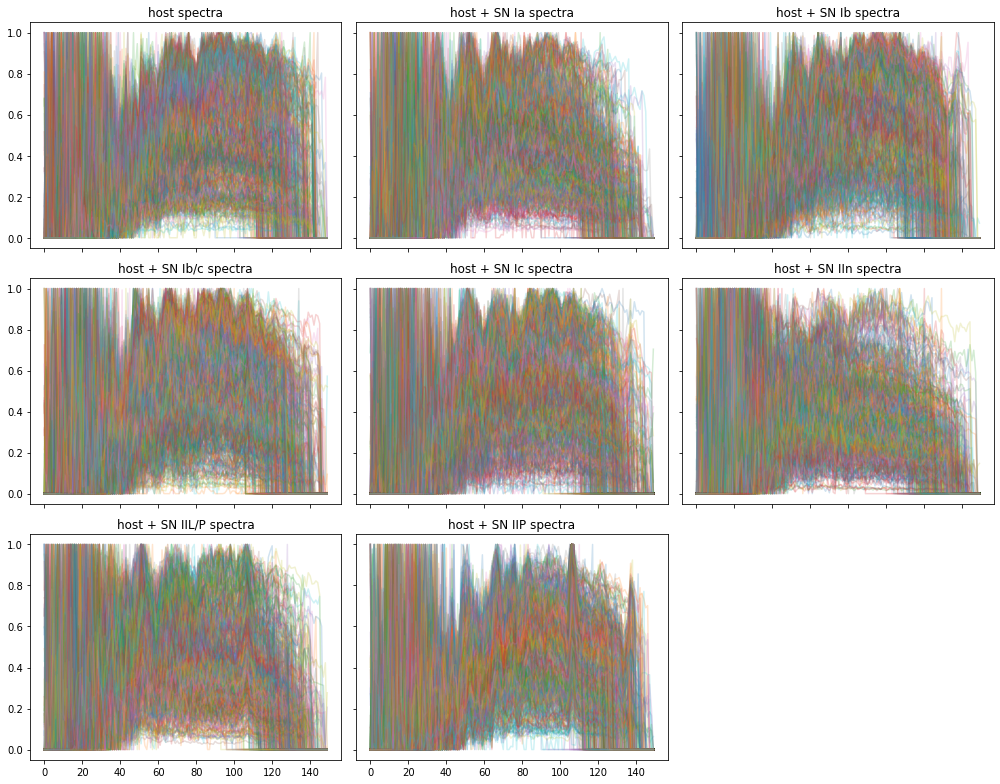

In [29]:
# PLOT
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snibc_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniin_flux[i], alpha=0.2)

    ax = axes[6]
    ax.plot(sniilp_flux[i], alpha=0.2)
    
    ax = axes[7]
    ax.plot(sniip_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ib/c spectra')
axes[4].set_title('host + SN Ic spectra')
axes[5].set_title('host + SN IIn spectra')
axes[6].set_title('host + SN IIL/P spectra')
axes[7].set_title('host + SN IIP spectra')

axes[8].axis('off')

fig.tight_layout()


x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7)
                       ]))

In [30]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM

In [31]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Accuracy

In [80]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 11s 184us/sample - loss: 2.4716 - acc: 0.4421 - val_loss: 1.9446 - val_acc: 0.5687
Epoch 2/50
58492/58492 [==============================] - 9s 151us/sample - loss: 1.7652 - acc: 0.5940 - val_loss: 1.6030 - val_acc: 0.6248
Epoch 3/50
58492/58492 [==============================] - 9s 151us/sample - loss: 1.5074 - acc: 0.6358 - val_loss: 1.4513 - val_acc: 0.6376
Epoch 4/50
58492/58492 [==============================] - 9s 153us/sample - loss: 1.3641 - acc: 0.6542 - val_loss: 1.3254 - val_acc: 0.6601
Epoch 5/50
58492/58492 [==============================] - 9s 151us/sample - loss: 1.2677 - acc: 0.6720 - val_loss: 1.2561 - val_acc: 0.6679
Epoch 6/50
58492/58492 [==============================] - 9s 152us/sample - loss: 1.2023 - acc: 0.6822 - val_loss: 1.2273 - val_acc: 0.6687
Epoch 7/50
58492/58492 [==============================] - 9s 153us/sample - loss: 1.1541 - acc: 0.6895 - val_

In [81]:
y_pred = model.predict(x_test)

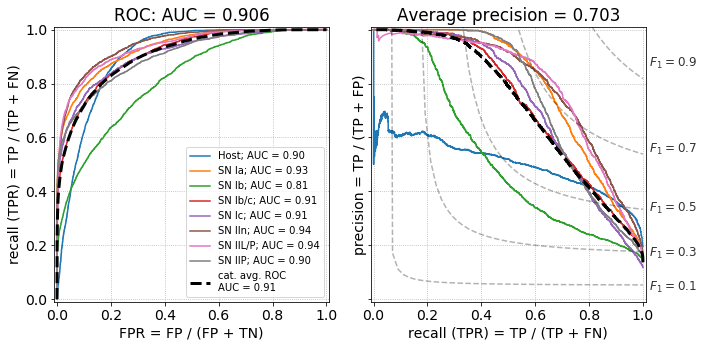

In [82]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

In [83]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [84]:
np.arange(cm.shape[1])

array([0, 1, 2, 3, 4, 5, 6, 7])

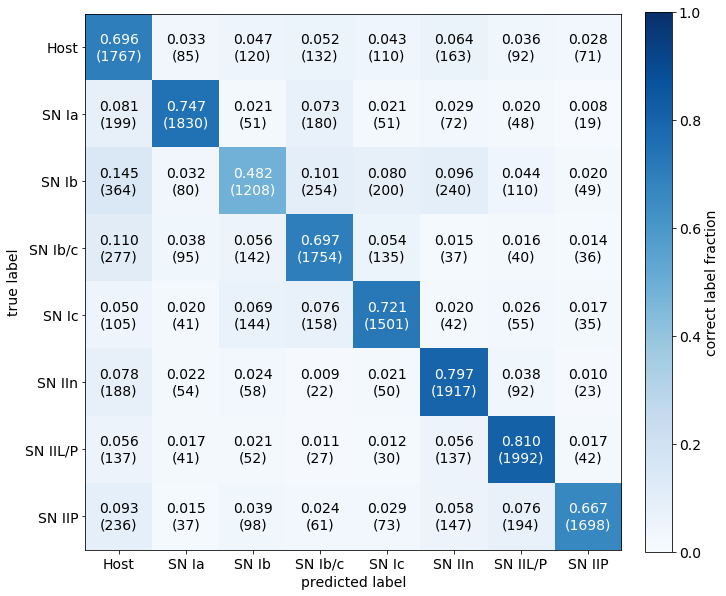

In [85]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# AUC

In [59]:
AUC = tf.keras.metrics.AUC(curve='PR')

In [60]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=[AUC,'accuracy'])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 11s 183us/sample - loss: 2.4746 - auc_4: 0.2180 - acc: 0.4245 - val_loss: 1.9425 - val_auc_4: 0.5357 - val_acc: 0.5613
Epoch 2/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.7540 - auc_4: 0.5595 - acc: 0.5880 - val_loss: 1.6005 - val_auc_4: 0.6079 - val_acc: 0.6150
Epoch 3/30
58492/58492 [==============================] - 10s 163us/sample - loss: 1.5007 - auc_4: 0.6101 - acc: 0.6308 - val_loss: 1.4447 - val_auc_4: 0.6421 - val_acc: 0.6345
Epoch 4/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.3570 - auc_4: 0.6347 - acc: 0.6542 - val_loss: 1.3228 - val_auc_4: 0.6690 - val_acc: 0.6593
Epoch 5/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.2646 - auc_4: 0.6490 - acc: 0.6690 - val_loss: 1.2577 - val_auc_4: 0.6689 - val_acc: 0.6677
Epoch 6/30
58492/58492 [==============================] - 10s 164

In [62]:
y_pred = model.predict(x_test)

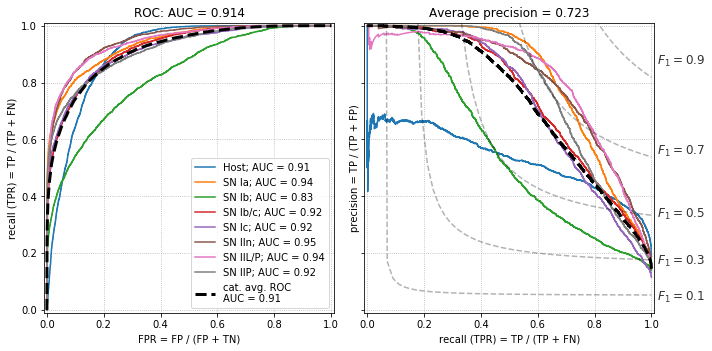

In [61]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

In [63]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

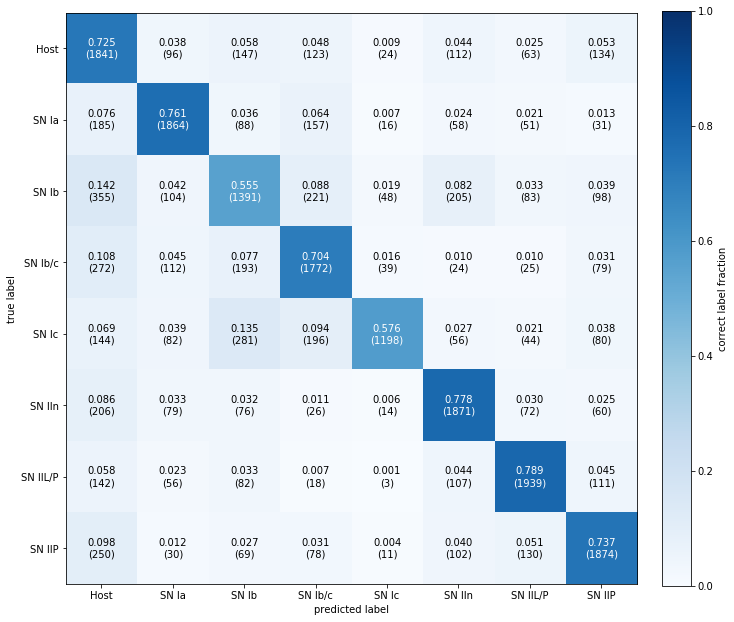

In [64]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# AUC

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 11s 183us/sample - loss: 2.4736 - auc_4: 0.2286 - val_loss: 1.9767 - val_auc_4: 0.5084
Epoch 2/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.7756 - auc_4: 0.5402 - val_loss: 1.6479 - val_auc_4: 0.6115
Epoch 3/30
58492/58492 [==============================] - 10s 163us/sample - loss: 1.5169 - auc_4: 0.5939 - val_loss: 1.4461 - val_auc_4: 0.6289
Epoch 4/30
58492/58492 [==============================] - 10s 163us/sample - loss: 1.3670 - auc_4: 0.6210 - val_loss: 1.3532 - val_auc_4: 0.6252
Epoch 5/30
58492/58492 [==============================] - 10s 166us/sample - loss: 1.2695 - auc_4: 0.6278 - val_loss: 1.2634 - val_auc_4: 0.6620
Epoch 6/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.2019 - auc_4: 0.6422 - val_loss: 1.2147 - val_auc_4: 0.6816
Epoch 7/30
58492/58492 [==============================] - 10s 163us/sample - los

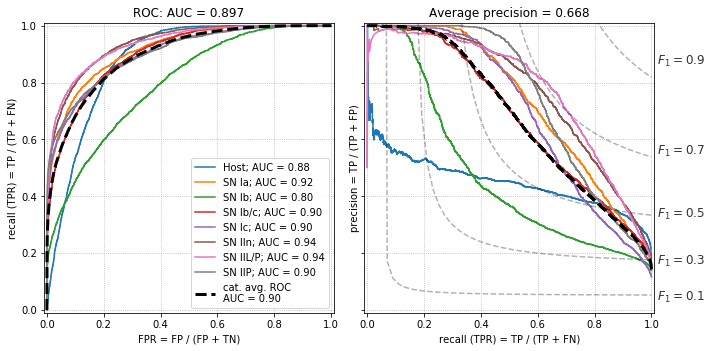

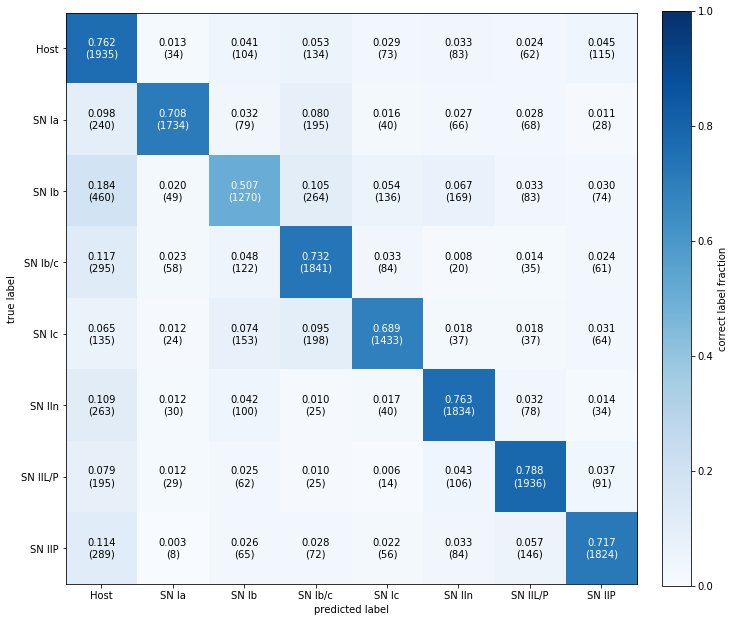

In [65]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=[AUC])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# Precision

In [66]:
precision = tf.keras.metrics.Precision()

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 10s 177us/sample - loss: 2.4435 - precision: 0.2404 - val_loss: 1.9314 - val_precision: 0.9475
Epoch 2/30
58492/58492 [==============================] - 9s 157us/sample - loss: 1.7578 - precision: 0.9612 - val_loss: 1.6046 - val_precision: 0.9815
Epoch 3/30
58492/58492 [==============================] - 9s 155us/sample - loss: 1.5067 - precision: 0.9796 - val_loss: 1.4475 - val_precision: 0.9920
Epoch 4/30
58492/58492 [==============================] - 9s 156us/sample - loss: 1.3616 - precision: 0.9827 - val_loss: 1.3561 - val_precision: 0.9914
Epoch 5/30
58492/58492 [==============================] - 9s 155us/sample - loss: 1.2679 - precision: 0.9899 - val_loss: 1.2539 - val_precision: 0.9956
Epoch 6/30
58492/58492 [==============================] - 9s 155us/sample - loss: 1.2033 - precision: 0.9881 - val_loss: 1.2234 - val_precision: 0.9855
Epoch 7/30
58492/58492 [=============

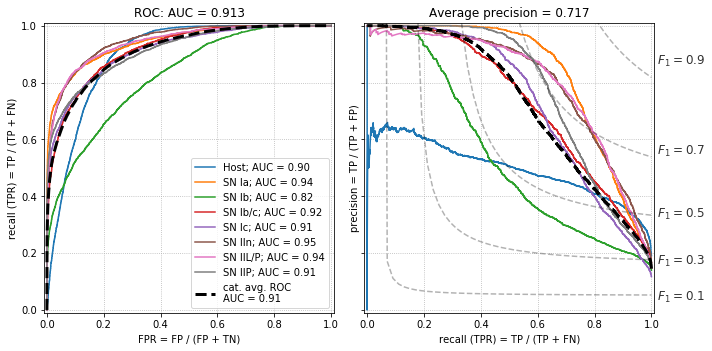

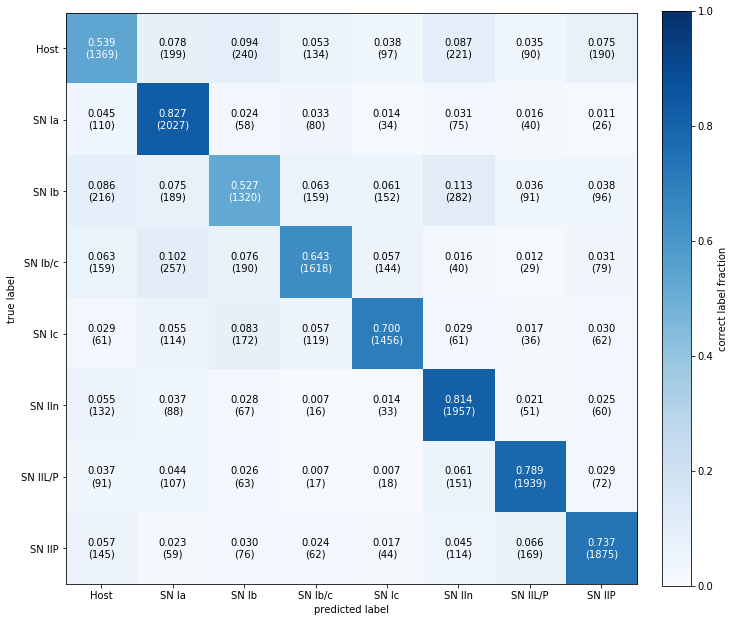

In [67]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=[precision])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# Precision + Accuracy

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 11s 181us/sample - loss: 2.4486 - precision: 0.2269 - acc: 0.4361 - val_loss: 1.9203 - val_precision: 0.9478 - val_acc: 0.5661
Epoch 2/30
58492/58492 [==============================] - 9s 158us/sample - loss: 1.7561 - precision: 0.9604 - acc: 0.5895 - val_loss: 1.6108 - val_precision: 0.9806 - val_acc: 0.6145
Epoch 3/30
58492/58492 [==============================] - 9s 158us/sample - loss: 1.5083 - precision: 0.9784 - acc: 0.6308 - val_loss: 1.4243 - val_precision: 0.9847 - val_acc: 0.6461
Epoch 4/30
58492/58492 [==============================] - 9s 158us/sample - loss: 1.3648 - precision: 0.9816 - acc: 0.6539 - val_loss: 1.3187 - val_precision: 0.9824 - val_acc: 0.6590
Epoch 5/30
58492/58492 [==============================] - 9s 159us/sample - loss: 1.2706 - precision: 0.9871 - acc: 0.6682 - val_loss: 1.2746 - val_precision: 0.9868 - val_acc: 0.6629
Epoch 6/30
58492/58492 [=====

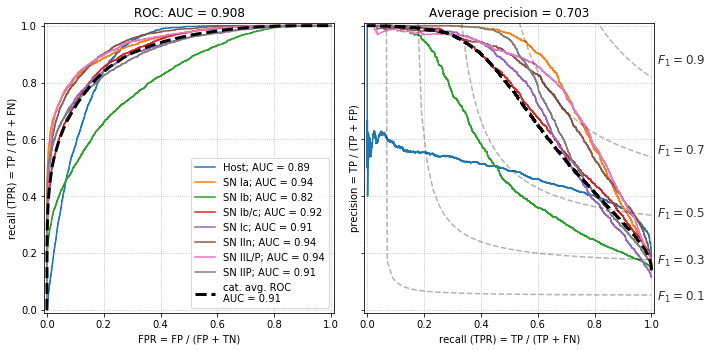

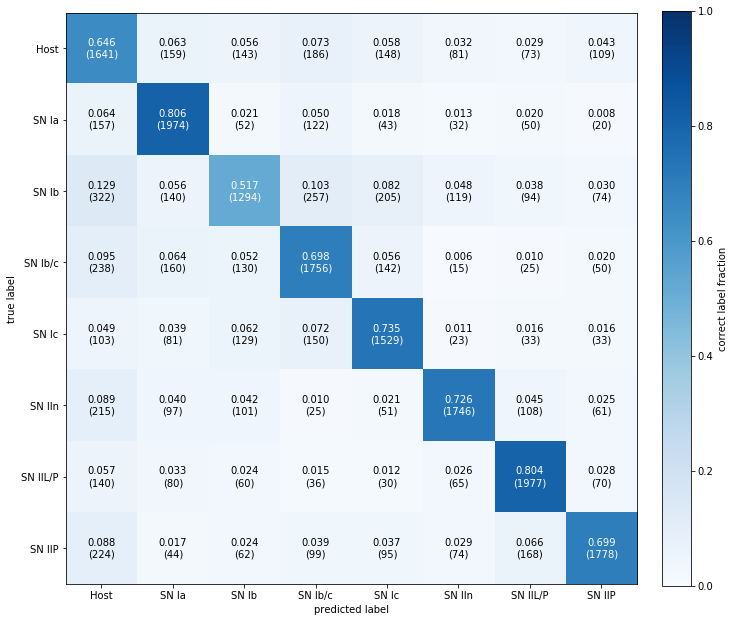

In [68]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=[precision,'accuracy'])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# BinaryCrossEntropy

In [34]:
# Accuracy

def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), shuffle=True)

W0728 09:16:08.661328 47255914460032 deprecation.py:323] From /software/tensorflow/2.0.0b/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 17s 285us/sample - loss: 0.8810 - acc: 0.8860 - val_loss: 0.4782 - val_acc: 0.9001
Epoch 2/50
58492/58492 [==============================] - 9s 146us/sample - loss: 0.3779 - acc: 0.9095 - val_loss: 0.3240 - val_acc: 0.9129
Epoch 3/50
58492/58492 [==============================] - 9s 146us/sample - loss: 0.3004 - acc: 0.9164 - val_loss: 0.2854 - val_acc: 0.9182
Epoch 4/50
58492/58492 [==============================] - 9s 146us/sample - loss: 0.2752 - acc: 0.9203 - val_loss: 0.2687 - val_acc: 0.9206
Epoch 5/50
58492/58492 [==============================] - 9s 146us/sample - loss: 0.2627 - acc: 0.9225 - val_loss: 0.2583 - val_acc: 0.9222
Epoch 6/50
58492/58492 [==============================] - 9s 146us/sample - loss: 0.2544 - acc: 0.9240 - val_loss: 0.2531 - val_acc: 0.9238
Epoch 7/50
58492/58492 [==============================] - 9s 146us/sample - loss: 0.2485 - acc: 0.9251 - val_

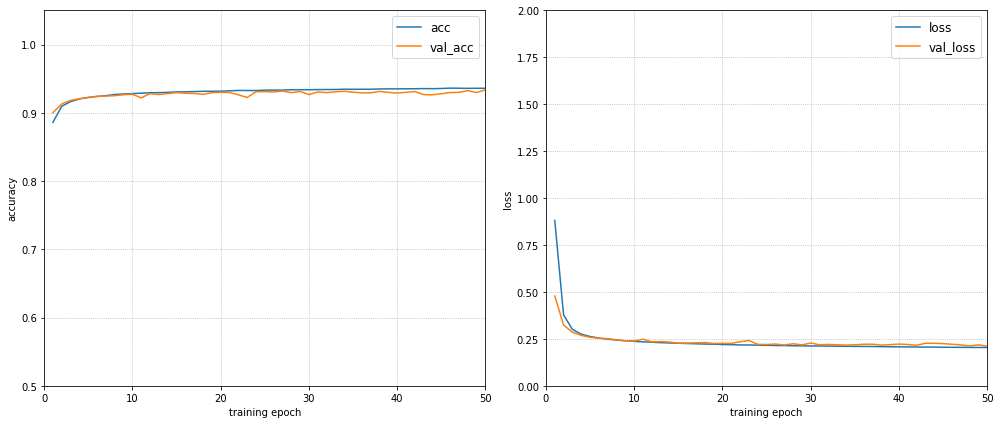

In [35]:
fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.05))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')
fig.tight_layout();

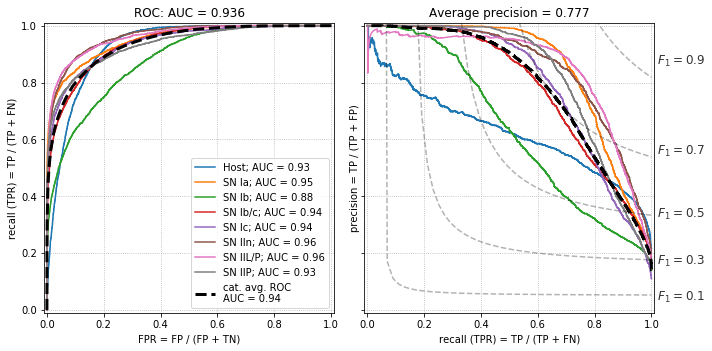

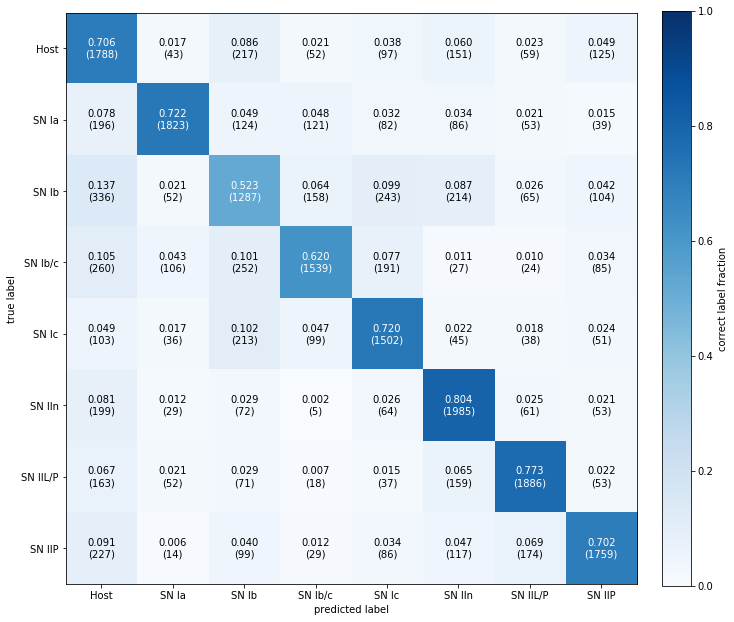

In [36]:
y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

In [39]:
# Accuracy

def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    precision = tf.keras.metrics.Precision()
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=[precision])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 10s 170us/sample - loss: 0.8419 - precision_1: 0.7558 - val_loss: 0.4577 - val_precision_1: 0.8169
Epoch 2/50
58492/58492 [==============================] - 9s 154us/sample - loss: 0.3697 - precision_1: 0.8309 - val_loss: 0.3205 - val_precision_1: 0.8421
Epoch 3/50
58492/58492 [==============================] - 9s 154us/sample - loss: 0.2985 - precision_1: 0.8416 - val_loss: 0.2879 - val_precision_1: 0.8412
Epoch 4/50
58492/58492 [==============================] - 9s 155us/sample - loss: 0.2753 - precision_1: 0.8458 - val_loss: 0.2702 - val_precision_1: 0.8547
Epoch 5/50
58492/58492 [==============================] - 9s 154us/sample - loss: 0.2624 - precision_1: 0.8484 - val_loss: 0.2618 - val_precision_1: 0.8399
Epoch 6/50
58492/58492 [==============================] - 9s 154us/sample - loss: 0.2546 - precision_1: 0.8522 - val_loss: 0.2578 - val_precision_1: 0.8124
Epoch 7/50
58

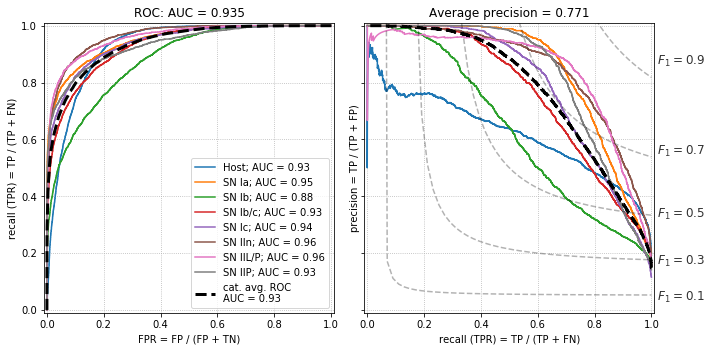

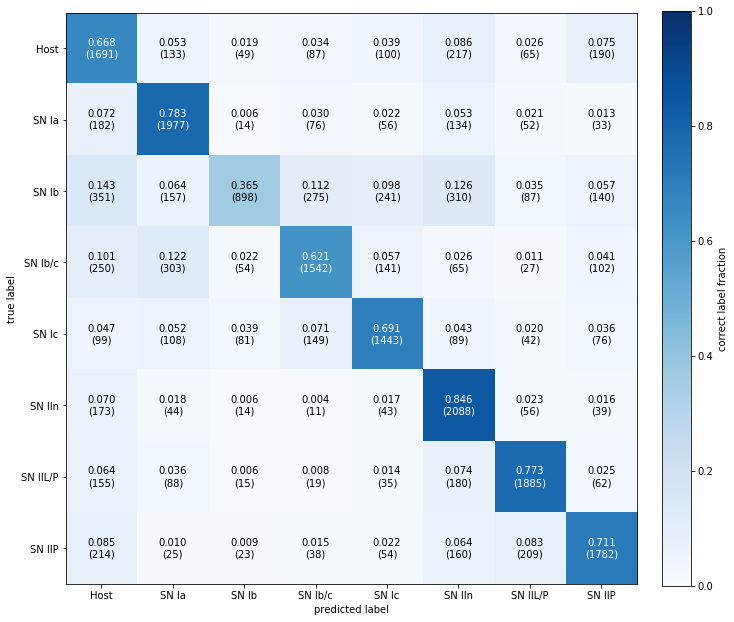

In [40]:
y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()